El objetivo es construir un modelo de regresión capaz de predecir el CVD Risk Score en pacientes adultos utilizando variables clínicas y demográficas.

## Cargar datos y librerias

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression


In [128]:
datos_pacientes = pd.read_csv('./data/Datos Lab 1.csv', sep=',')
data = datos_pacientes.copy()
data.head()
display(data.sample(5))
data.shape
data.info()


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
902,Lmau8226,"April 08, 2022",F,32.0,54.2,1.85,15.8,89.8,94/78,223.0,...,Moderate,N,185.0,0.485,94.0,78.0,Normal,115.0,14.32,INTERMEDIARY
1453,BIpz7536,13/01/2023,M,34.0,118.2,1.72,40.0,77.5,136/83,290.0,...,Low,N,172.0,0.451,136.0,83.0,Hypertension Stage 1,192.0,20.60,HIGH
771,TLNN1319,12-12-2021,M,56.0,116.2,1.67,41.7,97.6,149/66,173.0,...,High,N,167.0,0.584,149.0,66.0,Hypertension Stage 2,103.0,21.25,INTERMEDIARY
1072,MOdv1467,11-23-2022,F,59.0,54.1,NaN,16.0,102.1,101/86,150.0,...,Moderate,Y,184.0,0.555,101.0,86.0,Hypertension Stage 1,63.0,11.25,INTERMEDIARY
23,NvAn8170,24/03/2020,F,39.0,65.7,1.81,20.1,102.4,92/96,297.0,...,Low,Y,NaN,0.566,92.0,96.0,Hypertension Stage 2,202.0,16.56,HIGH


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1639 entries, 0 to 1638
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Patient ID                    1639 non-null   object 
 1   Date of Service               1639 non-null   object 
 2   Sex                           1639 non-null   object 
 3   Age                           1571 non-null   float64
 4   Weight (kg)                   1566 non-null   float64
 5   Height (m)                    1578 non-null   float64
 6   BMI                           1586 non-null   float64
 7   Abdominal Circumference (cm)  1578 non-null   float64
 8   Blood Pressure (mmHg)         1639 non-null   object 
 9   Total Cholesterol (mg/dL)     1571 non-null   float64
 10  HDL (mg/dL)                   1557 non-null   float64
 11  Fasting Blood Sugar (mg/dL)   1585 non-null   float64
 12  Smoking Status                1639 non-null   object 
 13  Dia

## Descripción de los datos

In [109]:
data.describe()

,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Estimated LDL (mg/dL),CVD Risk Score
count,1571.000000,1566.000000,1578.000000,1586.000000,1578.000000,1571.000000,1557.000000,1585.000000,1571.000000,1563.000000,1578.000000,1554.000000,1582.000000,1610.000000
mean,46.803186,85.666006,1.757439,28.424744,91.538861,199.043673,56.183558,117.836860,175.770082,0.522440,125.632637,82.887536,113.235896,18.227281
std,13.039479,21.712504,0.118012,7.309275,13.427985,59.388670,16.721702,32.379634,11.695880,0.085692,22.577463,15.503625,61.435291,10.767666
min,6.134000,13.261000,1.371000,4.317000,49.542000,-1.256000,0.008000,15.306000,136.498000,0.250000,49.914000,31.720000,-92.055000,-20.057000
25%,37.000000,67.100000,1.666500,22.600000,79.700000,150.000000,42.000000,92.000000,167.000000,0.453000,108.000000,71.000000,62.000000,15.150000
50%,46.000000,86.314000,1.760000,28.000000,91.200000,199.000000,56.000000,115.000000,176.000000,0.519000,125.000000,82.000000,112.000000,16.967000
75%,55.000000,104.801500,1.850000,33.963000,102.267250,250.000000,70.000000,139.000000,185.000000,0.582000,141.000000,93.000000,159.000000,18.900000
max,89.420000,158.523000,2.146000,53.028000,136.336000,385.679000,110.315000,219.667000,214.394000,0.804000,202.711000,134.066000,317.314000,114.980000


In [110]:
print(data['Sex'].value_counts(), '\n')
print(data['Physical Activity Level'].value_counts(), '\n')
print(data['Blood Pressure Category'].value_counts(), '\n')

Sex
M    821
F    818
Name: count, dtype: int64 

Physical Activity Level
High        582
Moderate    537
Low         520
Name: count, dtype: int64 

Blood Pressure Category
Hypertension Stage 2    680
Hypertension Stage 1    527
Normal                  321
Elevated                111
Name: count, dtype: int64 



In [111]:
print(data['Smoking Status'].value_counts(), '\n')
print(data['Diabetes Status'].value_counts(), '\n')
print(data['Family History of CVD'].value_counts(), '\n')

Smoking Status
Y    850
N    789
Name: count, dtype: int64 

Diabetes Status
N    821
Y    818
Name: count, dtype: int64 

Family History of CVD
N    820
Y    819
Name: count, dtype: int64 



## Calidad de datos
### Completitud

In [112]:
((data.isnull().sum()/data.shape[0])).sort_values(ascending=False)

Diastolic BP                    0.051861
HDL (mg/dL)                     0.050031
Waist-to-Height Ratio           0.046370
Weight (kg)                     0.044539
Total Cholesterol (mg/dL)       0.041489
Age                             0.041489
Height (cm)                     0.041489
Height (m)                      0.037218
Abdominal Circumference (cm)    0.037218
Systolic BP                     0.037218
Estimated LDL (mg/dL)           0.034777
Fasting Blood Sugar (mg/dL)     0.032947
BMI                             0.032337
CVD Risk Score                  0.017694
Sex                             0.000000
Patient ID                      0.000000
Date of Service                 0.000000
Family History of CVD           0.000000
Diabetes Status                 0.000000
Smoking Status                  0.000000
Blood Pressure (mmHg)           0.000000
Physical Activity Level         0.000000
Blood Pressure Category         0.000000
CVD Risk Level                  0.000000
dtype: float64

Las variables que cuentan con una completitud relativamente alta pues faltan entre 1% y 4% por lo que en estos casos donde estan vacias se inputaran con la mediana ya que a differencia de la media no tiene en cuenta los outliers. Tampoco se eliminan ya que esto implicaria perder mucha información.

### Unicidad

In [113]:
data.duplicated().sum()


np.int64(151)

Hay 252 registros duplicados (151 duplicas) para los cuales se decidio borrar todos los duplicados ya que pueden generar sesgo en el modelo al sobre-representar ciertos perfiles clínicos, afectando la generalización.

### Consistencia

Como pudimos observar previamente en la descripcion de las variables categoricas, todas son consistentes con sus categorias permitadas.

Ademas se puede observar que hay variables como Indice de masa, peso y altura, lo cual incrementa la multicolinealidad ya que se explican entre ellas y por lo tanto es pertinete revisar su relación posteriormente.

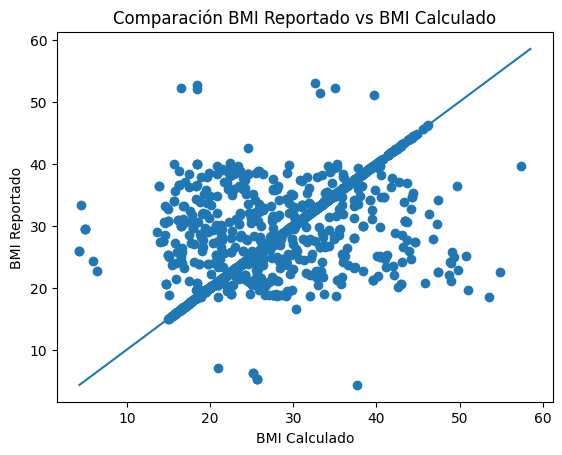

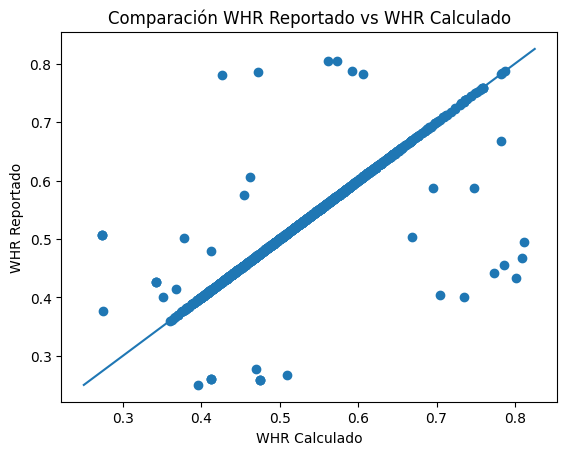

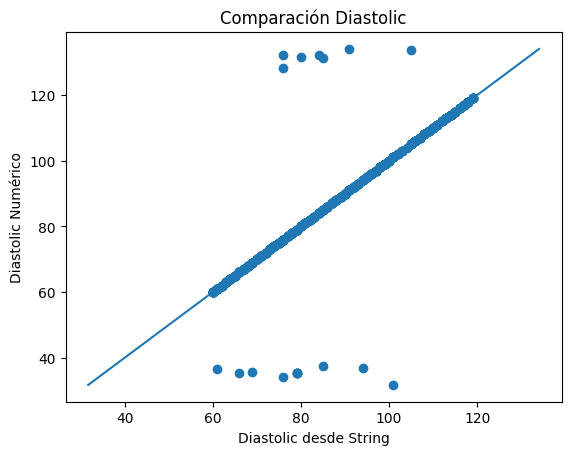

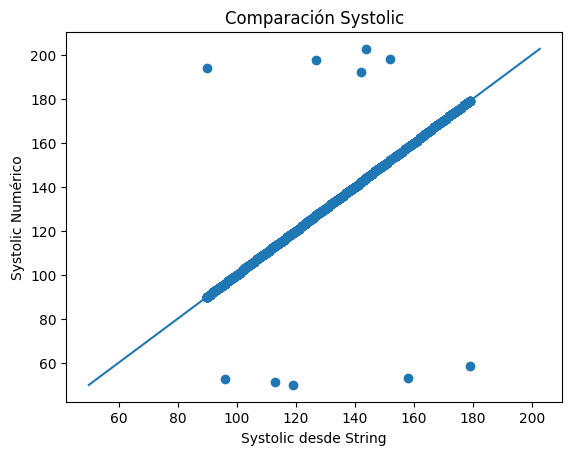

In [115]:
# Indice de masa
data['BMI_calculado'] = data['Weight (kg)'] / (data['Height (m)']**2)
plt.figure()
plt.scatter(data['BMI_calculado'], data['BMI'])
plt.xlabel("BMI Calculado")
plt.ylabel("BMI Reportado")
plt.title("Comparación BMI Reportado vs BMI Calculado")
min_val = min(data['BMI_calculado'].min(), data['BMI'].min())
max_val = max(data['BMI_calculado'].max(), data['BMI'].max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.show()

# Weight to height ratio

data['WHR_calculado'] = data['Abdominal Circumference (cm)'] / data['Height (cm)']
plt.figure()
plt.scatter(data['WHR_calculado'], data['Waist-to-Height Ratio'])
plt.xlabel("WHR Calculado")
plt.ylabel("WHR Reportado")
plt.title("Comparación WHR Reportado vs WHR Calculado")

min_val = min(data['WHR_calculado'].min(), data['Waist-to-Height Ratio'].min())
max_val = max(data['WHR_calculado'].max(), data['Waist-to-Height Ratio'].max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.show()

# Blood preassure

bp_split = data['Blood Pressure (mmHg)'].str.split('/', expand=True) # Blood preassure se calcula como Systolic/Diastolic entoonces se quiere verificar que sea consistente

data['Systolic_from_string'] = pd.to_numeric(bp_split[0], errors='coerce')
data['Diastolic_from_string'] = pd.to_numeric(bp_split[1], errors='coerce')

plt.figure()
plt.scatter(data['Diastolic_from_string'], data['Diastolic BP'])
plt.xlabel("Diastolic desde String")
plt.ylabel("Diastolic Numérico")
plt.title("Comparación Diastolic")

min_val = min(data['Diastolic BP'].min(), data['Diastolic_from_string'].min())
max_val = max(data['Diastolic BP'].max(), data['Diastolic_from_string'].max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.show()

plt.figure()
plt.scatter(data['Systolic_from_string'], data['Systolic BP'])
plt.xlabel("Systolic desde String")
plt.ylabel("Systolic Numérico")
plt.title("Comparación Systolic")

min_val = min(data['Systolic BP'].min(), data['Systolic_from_string'].min())
max_val = max(data['Systolic BP'].max(), data['Systolic_from_string'].max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.show()

# Eliminarlas del dataset

data.drop(columns=[
    'BMI_calculado',
    'WHR_calculado',
    'Systolic_from_string',
    'Diastolic_from_string'
], inplace=True, errors='ignore')




La presión de sangre y el weight to height ratio se mantiene consistente la relación por lo que los valores otorgados si comparten una relacion real con sus variables explicativas. Teniendo esto en cuenta, posteriormente en la manipulación de datos se pueden reducir estas variables para reducir la multicolinealidad de la regresión y mejorar su resultado. 

En el BMI por el contrario la grafica si muestra una dispersion fuerte e inconsisitente por lo que se eliminara y se recalculara a partir del peso y la altura de cada persona.

### Validez 

In [116]:
data.describe()


,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Estimated LDL (mg/dL),CVD Risk Score
count,1571.000000,1566.000000,1578.000000,1586.000000,1578.000000,1571.000000,1557.000000,1585.000000,1571.000000,1563.000000,1578.000000,1554.000000,1582.000000,1610.000000
mean,46.803186,85.666006,1.757439,28.424744,91.538861,199.043673,56.183558,117.836860,175.770082,0.522440,125.632637,82.887536,113.235896,18.227281
std,13.039479,21.712504,0.118012,7.309275,13.427985,59.388670,16.721702,32.379634,11.695880,0.085692,22.577463,15.503625,61.435291,10.767666
min,6.134000,13.261000,1.371000,4.317000,49.542000,-1.256000,0.008000,15.306000,136.498000,0.250000,49.914000,31.720000,-92.055000,-20.057000
25%,37.000000,67.100000,1.666500,22.600000,79.700000,150.000000,42.000000,92.000000,167.000000,0.453000,108.000000,71.000000,62.000000,15.150000
50%,46.000000,86.314000,1.760000,28.000000,91.200000,199.000000,56.000000,115.000000,176.000000,0.519000,125.000000,82.000000,112.000000,16.967000
75%,55.000000,104.801500,1.850000,33.963000,102.267250,250.000000,70.000000,139.000000,185.000000,0.582000,141.000000,93.000000,159.000000,18.900000
max,89.420000,158.523000,2.146000,53.028000,136.336000,385.679000,110.315000,219.667000,214.394000,0.804000,202.711000,134.066000,317.314000,114.980000


A partir del analisis preliminar de los datos de la funcion .describe() se puedieron encontrar las siguientes anomalias o datos atipicos:

- Se encontro registros con edades de minimo 6.13 años y dado el contexto el caso se enfoca en adultos jovenes y mayores por lo que se eliminaran todos los registros que tengan <18 años

- El colesterol total presenta valores negativas al igual que el Estimated LDL lo cual es fisiologicamente imposible por lo que se aceptaran datos unicamente con valores mayores a cero.

- Valores demasiado bajos en HDL y Fasting Blood Sugar. Se aceptaran los datos cuya HDL este entre 10 y 120 y su Fasting Blood Sugar entre 50-400

- Presiones arteriales inferiores a rangos compatibles con estabilidad. Se aceptaran rangos de Systolic BP entre 80 y 250 y para Diastolic entre 40 y 150

- Valores negativos en la variable objetivo de CVD Risk Score. Se tomaran en cuenta unicamente registros con CVD Risk Score mayor a cero.


Se utilizo ChatGPT para analizar el resultado de data.describe() y encontrar valores que para la respectiva categoria no deberian ser posibles o son atipicos y tambien conocer cuales son rangos que a pesar de ser extremos son aceptables. Estos ya que no conocemos mucho sobre los rangos esperados de ciertas mediciones.

### Correlación preliminar

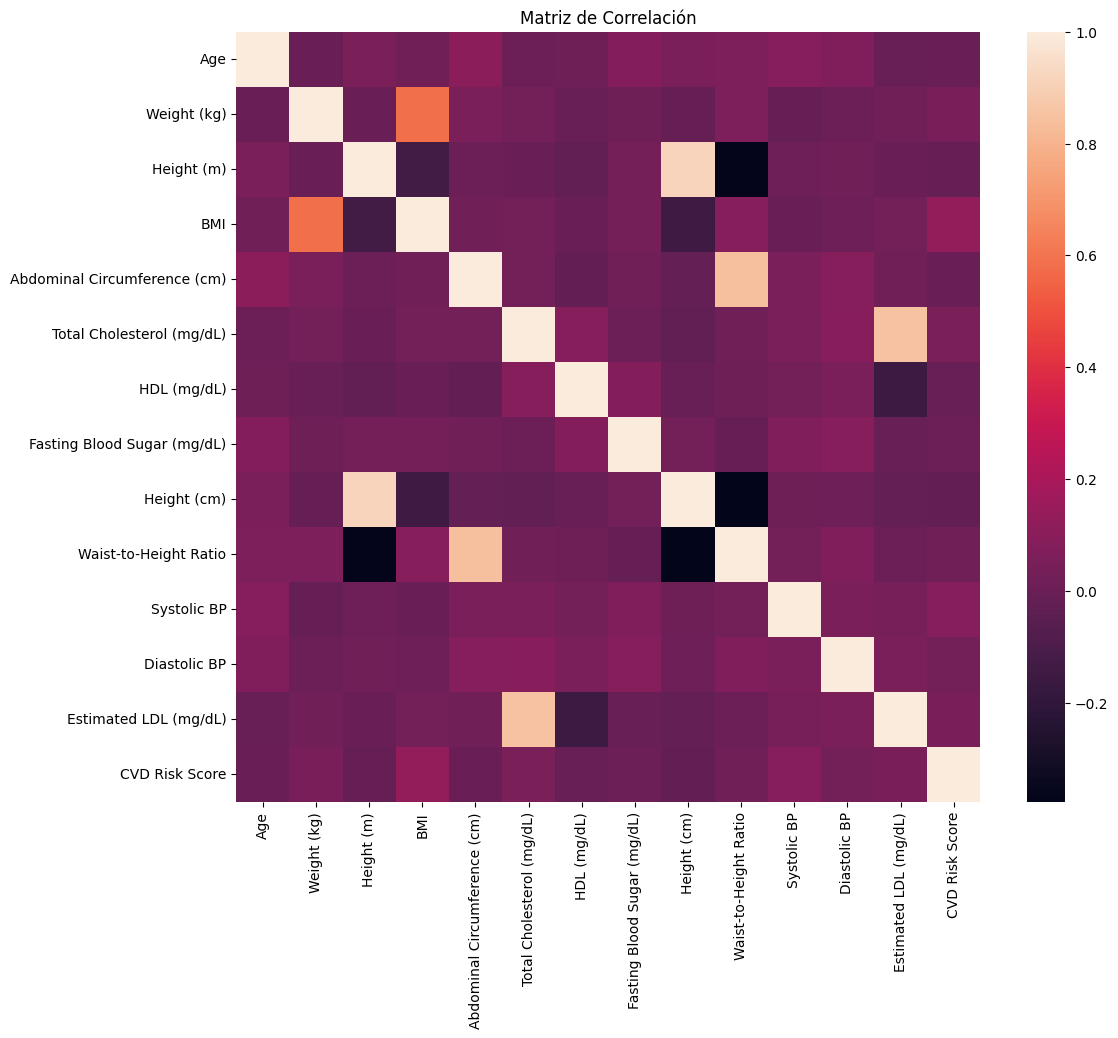

In [117]:
numeric_data = data.select_dtypes(include=['int64', 'float64'])

corr = numeric_data.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False)
plt.title("Matriz de Correlación")
plt.show()


Variables con alta correlación 

- Height(cm) y Height(m)
- Total Cholesterol y Estimated LDL
- Indice de masa y peso
- Waist to Height ratio y Height
- Indice de masa y altura


In [118]:
correlations = data.corr(numeric_only=True)["CVD Risk Score"].sort_values(ascending=False)
print(correlations)

CVD Risk Score                  1.000000
BMI                             0.133475
Systolic BP                     0.086767
Total Cholesterol (mg/dL)       0.053244
Estimated LDL (mg/dL)           0.043440
Weight (kg)                     0.042471
Diastolic BP                    0.026218
Waist-to-Height Ratio           0.020090
Fasting Blood Sugar (mg/dL)     0.000947
Abdominal Circumference (cm)   -0.000946
Age                            -0.004056
HDL (mg/dL)                    -0.011412
Height (m)                     -0.015594
Height (cm)                    -0.023800
Name: CVD Risk Score, dtype: float64


### Manipulación de datos

A partir de la exploracion de datos realizada se pudo observar que habian varias fallas en la calidad de datos pues estos en algunos casos contaban de datos atipicos, correlaciones entre las variables altas, registros repetidos y datos vacios.

En esta sección se va a hacer una manipulación de dautos de manera precavida de modo que se estandaricen y se corrigan las anomalias presentadas en los datos del manera que se utilice un data set con una alta calidad para poder construir el modelo adecuadamente. A continuación explicamos que lógica y metodos se utilizaron para esto:

Completitud: Se inputan los datos con la mediana, esta no esta sesgada por datos atipicos

Unicidad: Se eliminan por completo los registros duplicados

Consistencia: Se re calcula el Indice de masa corporal a partir de los datos de la persona ya que el ibm reportado no coincide con el calculado.

Validez: Se utilizaran unicamente los registros que esten dentro de los rangos permitidos para las diferentes variables y evitar asi datos atipicos y anomialias que puedan afectar el modelo.

Multicolinealidad: Se eliminaran las variables que encontramos se explicaban entre ellas durante la verificación de consistencia, y además se analizaran las variables con alta correlación de manera mas exhaustiva utilizando el indicador de VIF para revisar multicolinealidad.

In [129]:
data = data.drop_duplicates()

# Se eliminan Height (cm) y Waist-to-Height Ratio porque no aportan información adicional, Blood Pressure (mmHg) porque se puede calcular a partir de Systolic BP y Diastolic BP, y BMI porque se puede calcular a partir de Weight (kg) y Height (m).

data.drop(columns=[
    'Height (cm)',
    'Waist-to-Height Ratio',
    'Blood Pressure (mmHg)',
    'BMI'
], inplace=True)



data = data[data['Age'] >= 18]

data = data[data['Estimated LDL (mg/dL)'] > 0]
data = data[data['CVD Risk Score'] >= 0]

data = data[(data['HDL (mg/dL)'] >= 10) & 
            (data['HDL (mg/dL)'] <= 120)]

data = data[(data['Fasting Blood Sugar (mg/dL)'] >= 50) & 
            (data['Fasting Blood Sugar (mg/dL)'] <= 400)]

data = data[(data['Systolic BP'] >= 80) & 
            (data['Systolic BP'] <= 250)]

data = data[(data['Diastolic BP'] >= 40) & 
            (data['Diastolic BP'] <= 150)]

num_cols = data.select_dtypes(include=['int64','float64']).columns

imputer = SimpleImputer(strategy='median')
data[num_cols] = imputer.fit_transform(data[num_cols])




                        Variable         VIF
0                          const  373.965851
1                            Age    1.028701
2                    Weight (kg)    1.003242
3                     Height (m)    1.005894
4   Abdominal Circumference (cm)    1.021169
5      Total Cholesterol (mg/dL)    4.165984
6                    HDL (mg/dL)    1.279611
7    Fasting Blood Sugar (mg/dL)    1.034453
8                    Systolic BP    1.018765
9                   Diastolic BP    1.034193
10         Estimated LDL (mg/dL)    4.223316


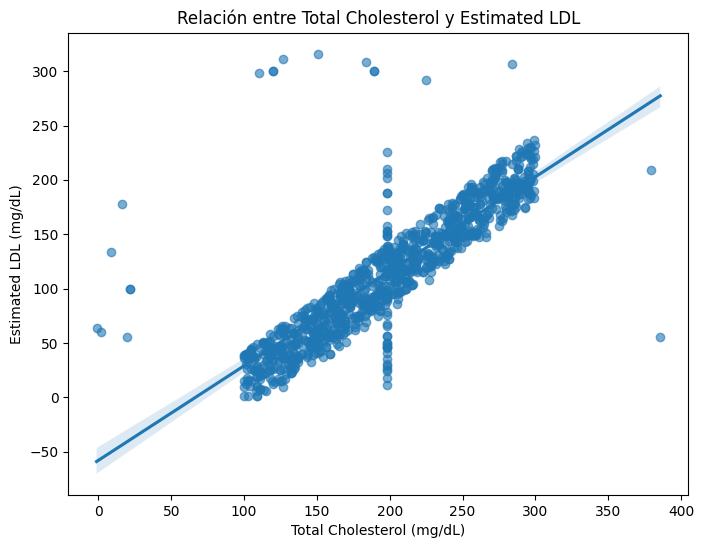

In [130]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = data.drop('CVD Risk Score', axis=1)

X = X.select_dtypes(include=['int64', 'float64'])

X = add_constant(X)

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)


plt.figure(figsize=(8,6))

sns.regplot(
    x='Total Cholesterol (mg/dL)', 
    y='Estimated LDL (mg/dL)', 
    data=data,
    scatter_kws={'alpha':0.6}
)

plt.title('Relación entre Total Cholesterol y Estimated LDL')
plt.xlabel('Total Cholesterol (mg/dL)')
plt.ylabel('Estimated LDL (mg/dL)')
plt.show()



Encontramos que Estimated LDL  y total Cholesterol tienen un VIF de 4.999 (si bien no es nada grave es relativamente alto), ádemas de eso en la grafica podemos observar que tienen una relación casi que directa por lo que se va a eliminar una de las dos. 

Dado esto se decidio eliminar una de las dos, en este caso se elimino el colesterol total

In [131]:
data.drop(columns=['Total Cholesterol (mg/dL)'], inplace=True)

#Confirmamos no quedan datos vacíos
print("datos vacios:", data.isna().sum().sum())



datos vacios: 0


In [132]:
data.head() # Revisamos con que quedamos


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),Abdominal Circumference (cm),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
0,isDx5313,"November 08, 2023",M,44.0,114.300,1.720,100.000,77.0,91.0,Y,Y,High,N,112.0,83.0,Hypertension Stage 1,121.0,19.880,HIGH
1,LHCK2961,20/03/2024,F,57.0,92.923,1.842,106.315,71.0,76.0,N,Y,High,Y,101.0,91.0,Hypertension Stage 2,57.0,16.833,INTERMEDIARY
3,dCDO1109,"April 18, 2022",F,35.0,113.300,1.780,79.600,34.0,111.0,Y,N,Moderate,Y,92.0,89.0,Hypertension Stage 1,94.0,14.920,HIGH
4,pnpE1080,01/11/2024,F,48.0,102.200,1.750,106.700,49.0,147.0,Y,Y,Low,Y,121.0,68.0,Elevated,128.0,18.870,HIGH
5,MQyB2747,25 Mar 24,M,43.0,52.700,1.850,107.700,32.0,70.0,Y,N,High,N,107.0,61.0,Normal,43.0,10.530,INTERMEDIARY


### Analizar variable objetivo

In [133]:
data["CVD Risk Score"].describe()

count    1083.000000
mean       18.640632
std        11.341848
min         0.883000
25%        15.210000
50%        17.050000
75%        19.040000
max       114.980000
Name: CVD Risk Score, dtype: float64

Cuenta con outliers muy fuertes por lo que elimine outliers 

In [134]:
Q1 = data["CVD Risk Score"].quantile(0.25)
Q3 = data["CVD Risk Score"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[
    (data["CVD Risk Score"] >= lower_bound) &
    (data["CVD Risk Score"] <= upper_bound)
]


data["CVD Risk Score"].describe()

count    1025.000000
mean       17.027035
std         2.544114
min        10.530000
25%        15.230000
50%        16.920000
75%        18.830000
max        24.449000
Name: CVD Risk Score, dtype: float64

## Modelo predictivo

### Definicion de variable objetivo y predictoras

En esta sección se define la variable objetivo (CVD Risk Score) y el conjunto de variables predictoras.
Dado que se trata de una variable continua, el problema corresponde a una tarea de regresión supervisada.

In [135]:
# Separar variables predictoras y objetivo
print(data.groupby("CVD Risk Level")["CVD Risk Score"].describe())

# Eliminamos la variable objetivo categórica, no es coherente con el risk score, y no aporta información adicional.
data = data.drop("CVD Risk Level", axis=1)
data = data.drop("Patient ID", axis=1)
data = data.drop("Date of Service", axis=1)


X = data.drop("CVD Risk Score", axis=1)
y = data["CVD Risk Score"]

print("\nDimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)


                count       mean       std    min      25%      50%       75%  \
CVD Risk Level                                                                  
HIGH            498.0  17.540299  2.318949  10.89  16.0200  17.5855  19.24925   
INTERMEDIARY    380.0  16.319305  2.527216  10.53  14.5825  16.0695  17.87250   
LOW             147.0  17.117728  2.881069  10.86  14.4715  16.9210  19.37250   

                   max  
CVD Risk Level          
HIGH            24.449  
INTERMEDIARY    23.510  
LOW             23.797  

Dimensiones de X: (1025, 15)
Dimensiones de y: (1025,)


La variable CVD Risk Level fue eliminada porque no presenta coherencia estadística ni relación estructurada con la variable objetivo.

### Identificacion de variables numericas y categoricas

In [136]:
# Identificar tipos de variables
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Variables numéricas:", numeric_features)
print("Variables categóricas:", categorical_features)





Variables numéricas: ['Age', 'Weight (kg)', 'Height (m)', 'Abdominal Circumference (cm)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Systolic BP', 'Diastolic BP', 'Estimated LDL (mg/dL)']
Variables categóricas: ['Sex', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Blood Pressure Category']


Revision entre relacion de variables explicativas y objetivo

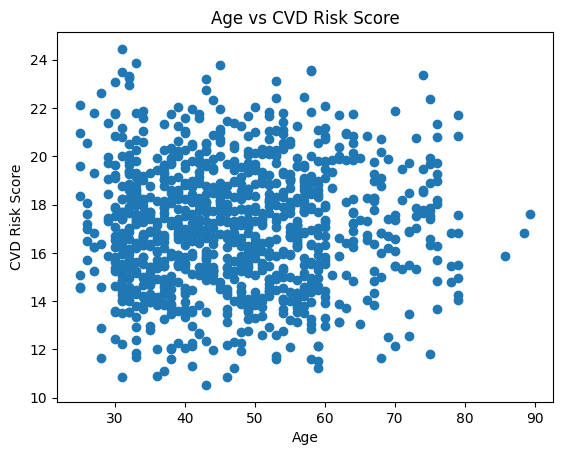

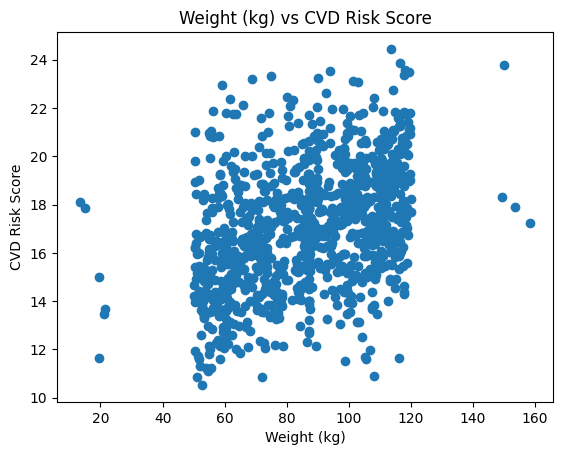

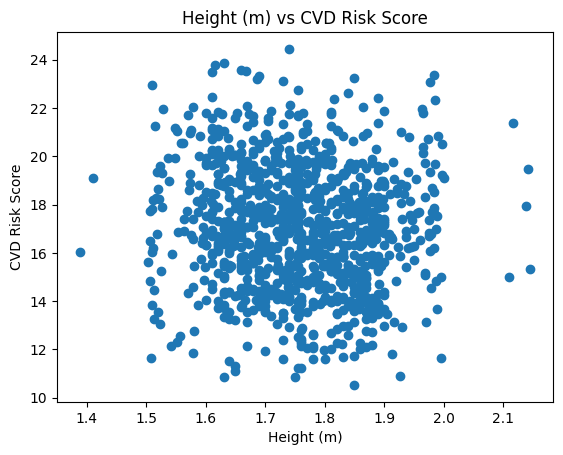

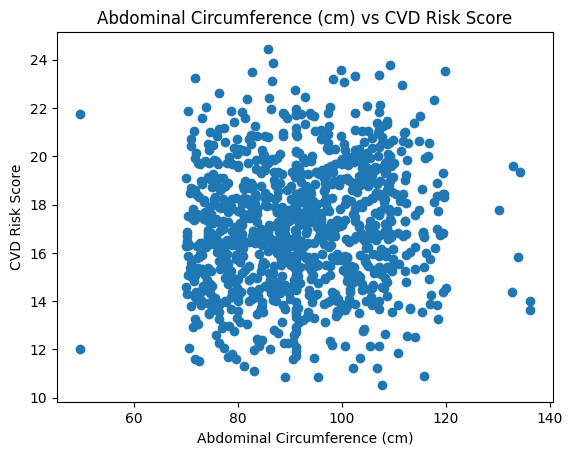

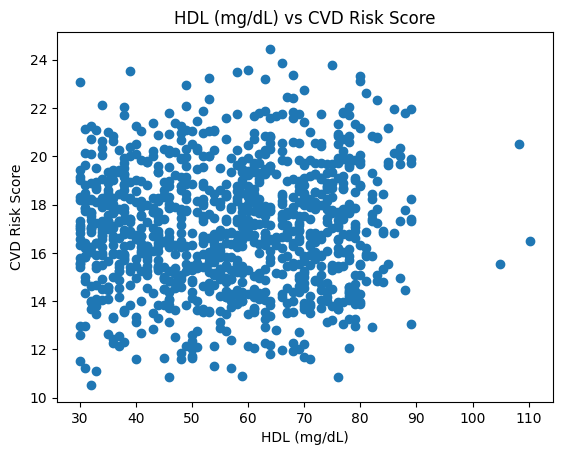

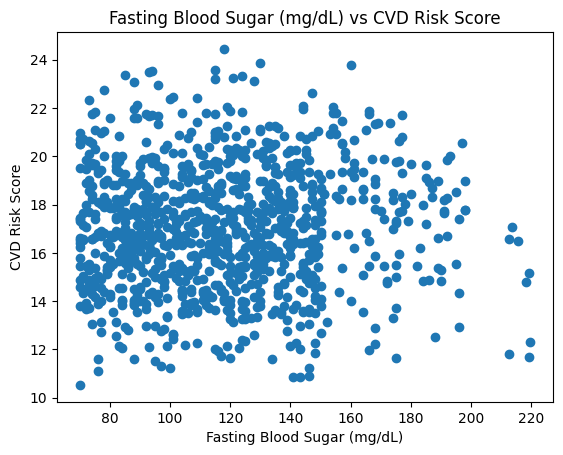

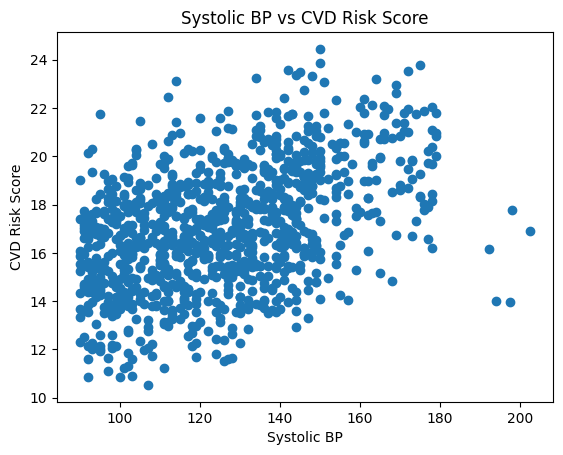

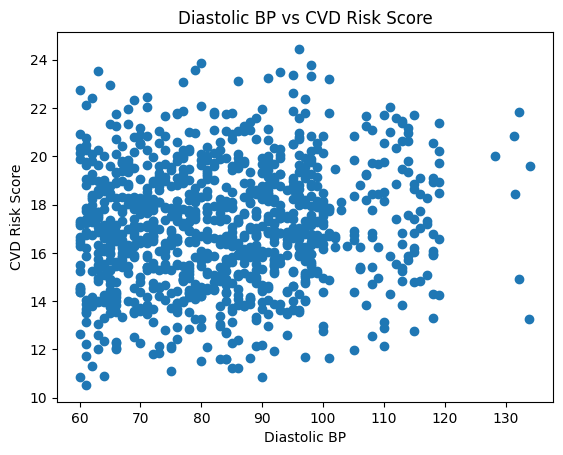

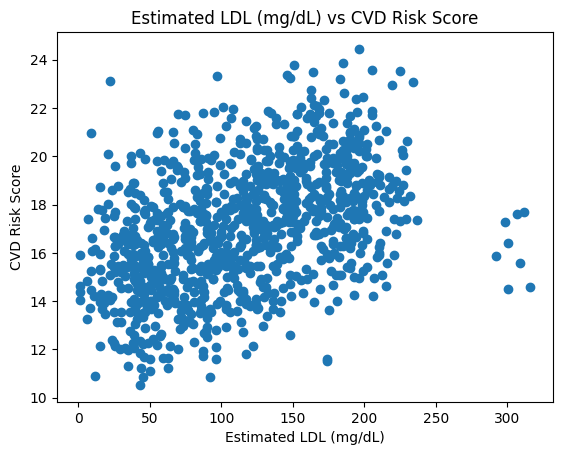

<Figure size 640x480 with 0 Axes>

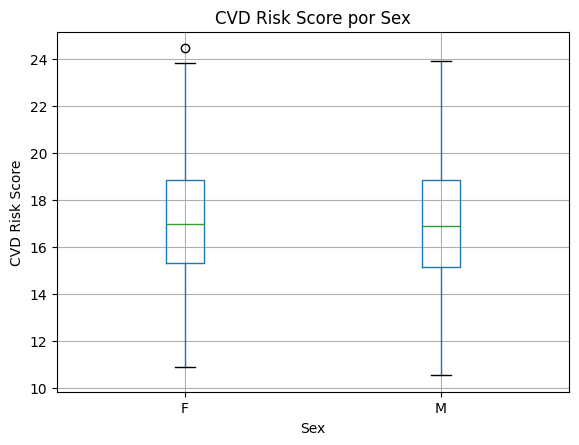

<Figure size 640x480 with 0 Axes>

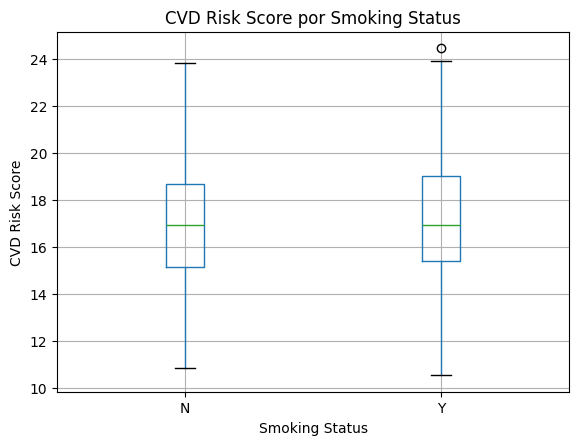

<Figure size 640x480 with 0 Axes>

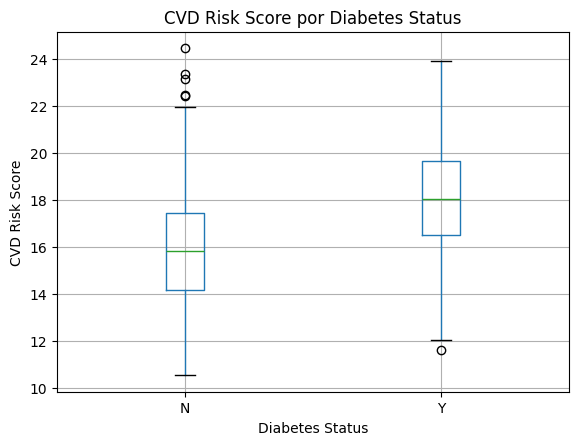

<Figure size 640x480 with 0 Axes>

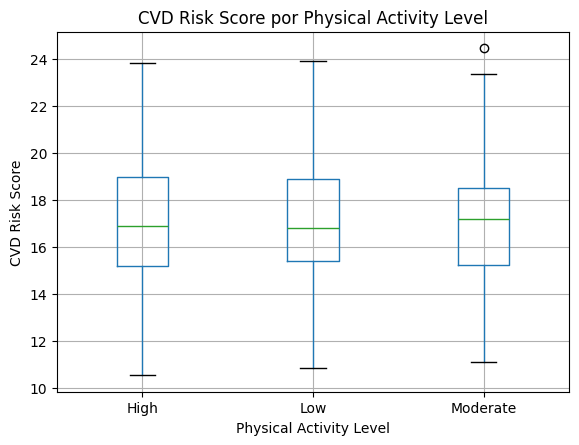

<Figure size 640x480 with 0 Axes>

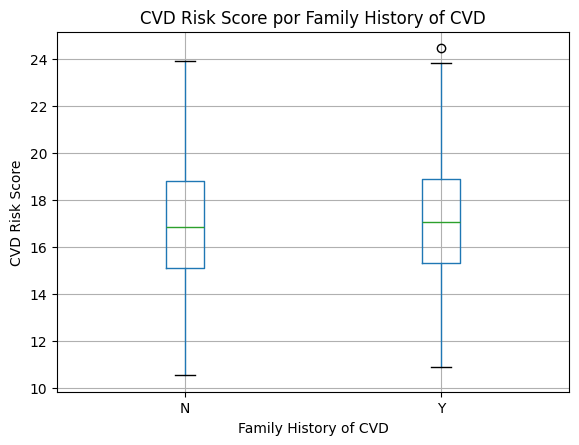

<Figure size 640x480 with 0 Axes>

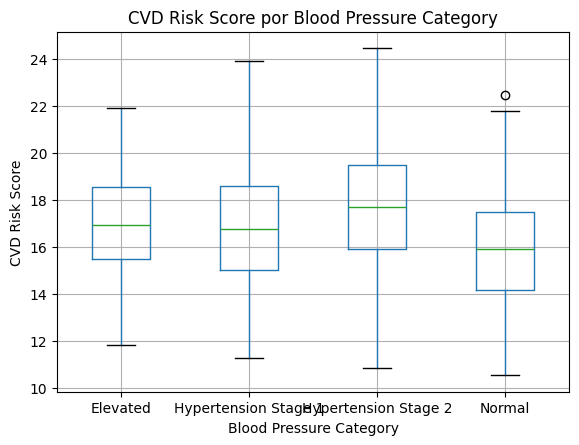

In [137]:
for col in numeric_features:
    if col != "CVD Risk Score":
        plt.figure()
        plt.scatter(data[col], data["CVD Risk Score"])
        plt.xlabel(col)
        plt.ylabel("CVD Risk Score")
        plt.title(f"{col} vs CVD Risk Score")
        plt.show()

for col in categorical_features:
    plt.figure()
    data.boxplot(column="CVD Risk Score", by=col)
    plt.title(f"CVD Risk Score por {col}")
    plt.suptitle("")
    plt.xlabel(col)
    plt.ylabel("CVD Risk Score")
    plt.show()


Las variables que presentan alguna relacion / tendencia son:

- Systolic BP
- Diabetes Status 
- Estimated LDL
- Blood Pressure Category

### Division entrenamiento 

Se realiza una división del conjunto de datos en entrenamiento (80%) y prueba (20%) con el fin de evaluar el desempeño del modelo en datos no vistos durante el entrenamiento.

In [138]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (820, 15)
Test shape: (205, 15)


### Construccion del pipeline

Se construye un pipeline que incluye:

- Escalamiento de variables numéricas

- Codificación One-Hot para variables categóricas

- Modelo de regresión lineal

In [139]:

# Transformaciones
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

# Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Pipeline completo
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])


### Entrenar el modelo

Se entrena el modelo utilizando únicamente el conjunto de entrenamiento.

In [140]:
model.fit(X_train, y_train) 

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

## Evaluación del modelo

### Medidas
Se evalua el desempeño del modelo utilizando metricas de regresión como:
- R^2 
- MAE
- RMSE

In [141]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predicciones
y_pred = model.predict(X_test)

# Métricas
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R²:", r2)
print("MAE:", mae)
print("RMSE:", rmse)


R²: 0.5848915683517856
MAE: 1.058166904844221
RMSE: 1.5980674149781127


### Graficas de Real vs Predicho

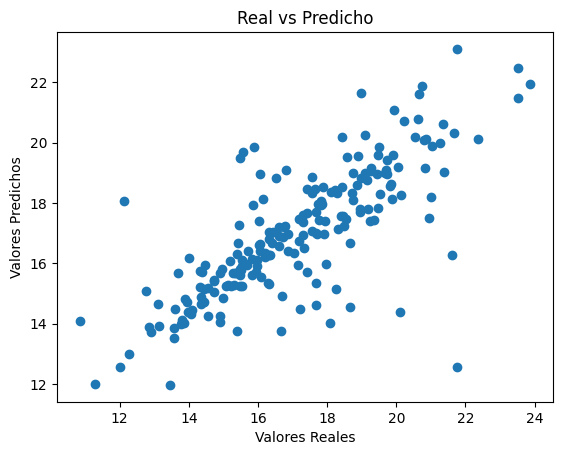

In [142]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Real vs Predicho")
plt.show()


### Grafico de residuos

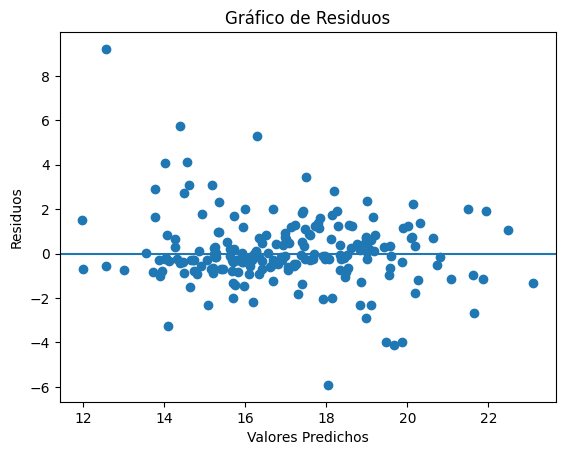

In [143]:
residuals = y_test - y_pred

plt.figure()
plt.scatter(y_pred, residuals)
plt.axhline(y=0)
plt.xlabel("Valores Predichos")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos")
plt.show()
